In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMapSolver
import inspect

from scene_objects import create_scene_objects, gather_bboxes, visualize_scene_collisions
from motion_engine import MotionEngine

# Set Mitsuba variant
mi.set_variant("llvm_ad_mono_polarized")

In [2]:
# Get all functions in the class
for name, func in inspect.getmembers(MotionEngine, predicate=inspect.isfunction):
    sig = inspect.signature(func)
    print(f"{name}{sig}")

__init__(self, scene, bounds=None)
add_random_walk(self, jammer_id, starting_position, num_steps, step_size, time_step=0.1, z_fixed=True, random_seed=None)
create_path_matrix(self, padding_mode='pad_end')
get_all_positions_at_step(self, step_index)
get_max_path_length(self)
get_position_at_step(self, jammer_id, step_index)
update_scene_transmitters(self, step_index)


In [3]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\testy\DowntownChicago1KM.xml"
scene = load_scene(scene_path)

In [4]:
bounds, map_center, map_size, cell_size = create_scene_objects(scene)
map_width, map_height = map_size

In [5]:
engine = MotionEngine(scene, bounds=bounds)

# Add jammer paths
engine.add_random_walk("Tx1", starting_position=[70, -10, 10], num_steps=3, step_size=10.0, time_step=1.0)
engine.add_random_walk("Tx2", starting_position=[-260, 100, 10], num_steps=5, step_size=10.0, time_step=1.0)

# Create synchronized padded paths
padded_paths, max_steps = engine.create_path_matrix(padding_mode='pad_end')

Generated path for 'Tx1': Total distance: 20.00 m, Avg velocity: 10.00 m/s
Generated path for 'Tx2': Total distance: 40.00 m, Avg velocity: 10.00 m/s
Padded 'Tx1' from 3 to 5 steps (mode: pad_end)


Tx1 position: [70.0, -10.0, 10.0]
Tx2 position: [-260.0, 100.0, 10.0]
Tx1 position: [74.1, -19.1, 10.0]
Tx2 position: [-260.7, 110.0, 10.0]
Tx1 position: [84.1, -17.8, 10.0]
Tx2 position: [-256.8, 100.8, 10.0]
Tx2 position: [-266.7, 99.3, 10.0]
Tx2 position: [-257.2, 102.7, 10.0]


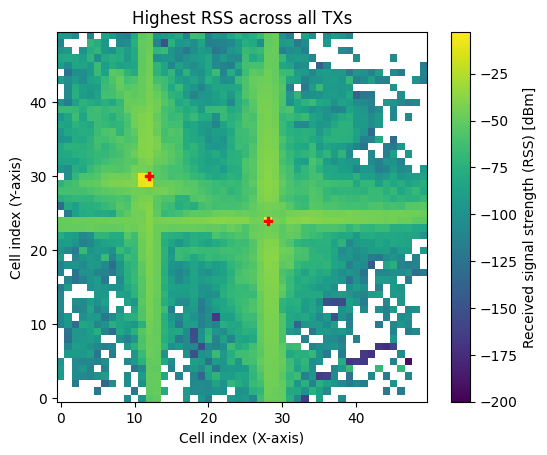

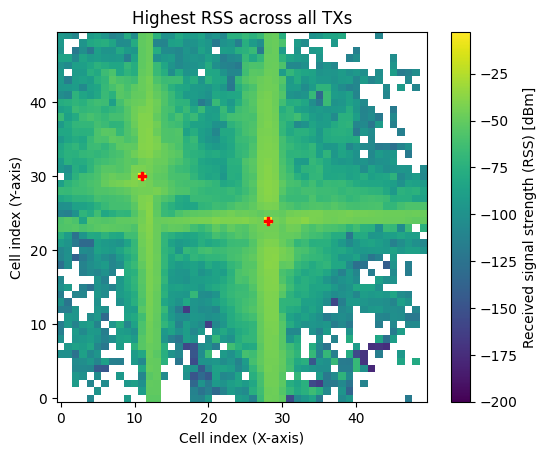

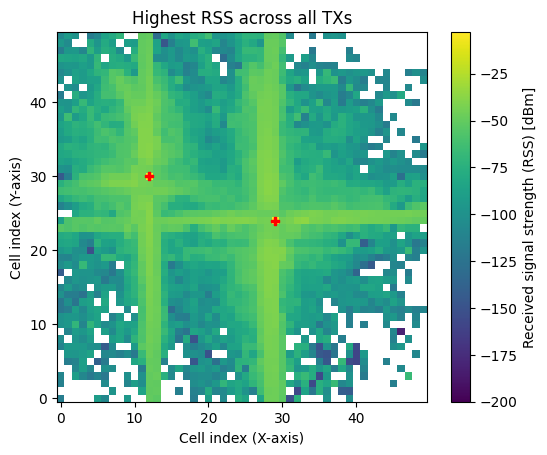

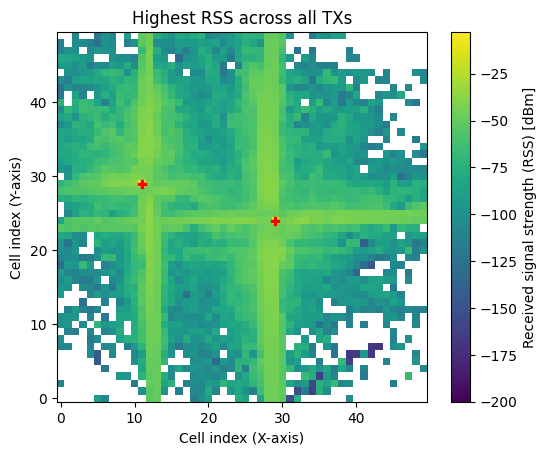

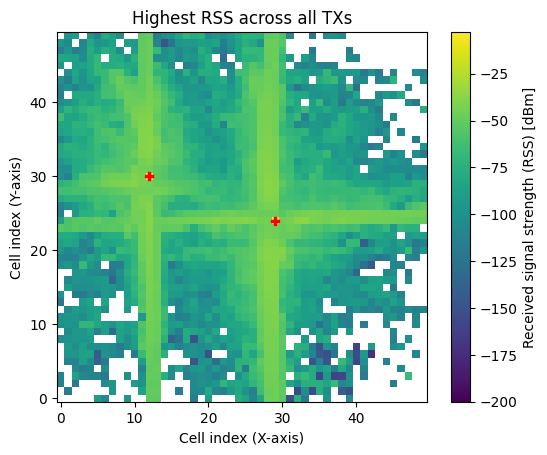

In [6]:
rm_solver = RadioMapSolver()

for step in range(max_steps):
    # Update transmitter positions
    engine.update_scene_transmitters(step)
    
    # Print current positions
    positions = engine.get_all_positions_at_step(step)
    for jammer_id, pos in positions.items():
        print(f"{jammer_id} position: [{pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f}]")
    
    # Compute radio map
    rm = rm_solver(
        scene,
        max_depth=10,
        samples_per_tx=10**6,  # Adjust for speed/memory
        cell_size=cell_size,
        center=map_center,
        size=[map_width, map_height],
        orientation=[0, 0, 0],
        diffraction=True,
        refraction=True,
        edge_diffraction=True
    )
    
    # Display radio map
    rm.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [7]:
print(padded_paths)

{'Tx1': array([[ 70.        , -10.        ,  10.        ],
       [ 74.13843371, -19.10348101,  10.        ],
       [ 84.05913039, -17.8465891 ,  10.        ],
       [ 84.05913039, -17.8465891 ,  10.        ],
       [ 84.05913039, -17.8465891 ,  10.        ]]), 'Tx2': array([[-260.        ,  100.        ,   10.        ],
       [-260.65816519,  109.97831742,   10.        ],
       [-256.77456581,  100.76323978,   10.        ],
       [-266.67068302,   99.32558049,   10.        ],
       [-257.24790142,  102.67389154,   10.        ]])}


Processed 463 unique structures.


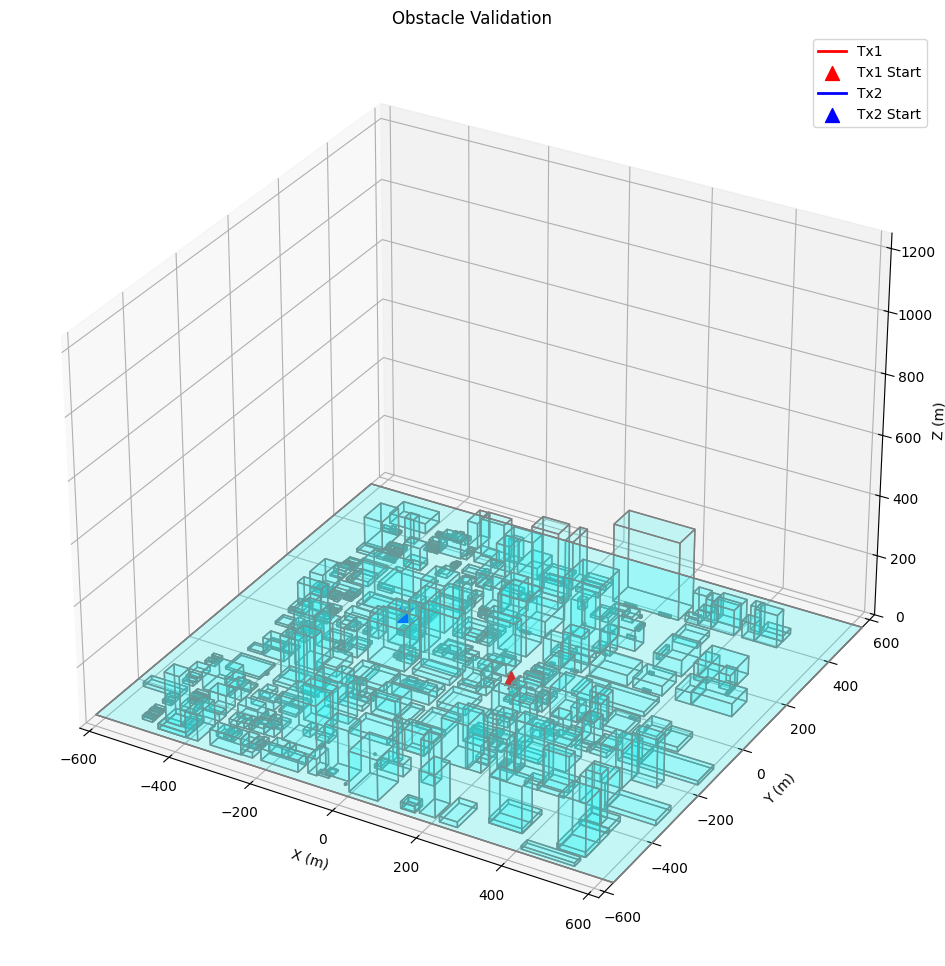

In [8]:
building_data = gather_bboxes(r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\testy\meshes")
visualize_scene_collisions(building_data, engine.jammer_paths)

In [9]:
print(building_data)

[{'name': '21C_Museum_Hotel_Chicago', 'min': array([ -75.93996429, -144.57995605,    0.        ]), 'max': array([ -33.91827393, -110.88272858,   18.39087486])}, {'name': '21_West_Chestnut', 'min': array([-333.69882202,  377.31936646,    0.        ]), 'max': array([-279.21102905,  411.71633911,   57.01076508])}, {'name': '2_East_Erie', 'min': array([-239.42388916,   -3.01590395,    0.        ]), 'max': array([-184.31958008,   33.53017426,  121.09442902])}, {'name': '30_East_Huron_Private_Residences', 'min': array([-129.76324463,   89.54650879,    0.        ]), 'max': array([-107.72141266,  130.50114441,  173.14633179])}, {'name': '407_North_Clark_Street', 'min': array([-480.26202393, -542.73193359,    0.        ]), 'max': array([-410.05697632, -474.35067749,   16.64012146])}, {'name': '444_North_Michigan', 'min': array([  12.00471497, -401.83724976,    0.        ]), 'max': array([  25.8193512, -386.2409668,  135.6000061])}, {'name': '500_North_Michigan', 'min': array([  11.5222168 , -35